# 전처리 가설 검증
- df_train + 추가데이터 전부 사용  
- 5개 나라에 대해서만 진행('칠레', '중국', '노르웨이', '태국', '베트남') > ctry_list 변수에 포함되어 있음
- 주요 수출국별 주요 어종 모델 3개 생성 (오징어,연어,흰다리새우)

In [1]:
from utility import *

# Setting

### Library

In [2]:
# Turn off warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
# Visualization Setting
color_palette = 'Set3'
title_size = 20
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'NanumGothic'

In [4]:
def RMSE(y, y_pred):
    return mean_squared_error(y, y_pred)**0.5


def train_model(train_data, target_data, model=LinearRegression()):  # baseline model : LInearRegression
    x_train, x_test, y_train, y_test = train_test_split(train_data, target_data, random_state=0)

    model.fit(x_train, y_train)
    print("Model Training Complete!")

    pred_train, pred_test = model.predict(x_train), model.predict(x_test)
    
    plt.figure(figsize=(10, 8))
#     plt.scatter(pred_train, y_train, s=10)
    sns.regplot(pred_train, y_train, color='g')
    plt.xlabel("Predicted price")
    plt.ylabel("Actual price")
    plt.show()

    # cvs = cross_val_score(model, x_test, y_test, cv = 5)
    # print(">> cross_val_score mean =", cvs.mean())
    print(">> RMSE train =", RMSE(y_train, pred_train))
    print(">> RMSE validation =", RMSE(y_test, pred_test))
    print(">> MAE train =", mean_absolute_error(pred_train, y_train))
    print(">> MAE validation =", mean_absolute_error(pred_test, y_test))
    print("-------------------------------------------------")
    
    return model

    
def print_importance(model, df, added_columns):
    importance = model.coef_
    fs_data = []
    for i, x in enumerate(importance):
        fs_data.append([abs(x), df.columns[i]])
    fs_data.sort(key=lambda x: x[0], reverse=True)
   
    # 추가한 컬럼의 중요도
    for i in range(len(fs_data)):
        if fs_data[i][1] in added_columns:
            print(fs_data[i][1], ":", fs_data[i][0] ,">", i, "순위")
    print("-------------------------------------------------")
    print("총", len(fs_data) , "개")
    
    return fs_data

In [5]:
# Data directory
root = os.path.join(os.getcwd(), 'DATA')

### Merging dataframes

In [6]:
from functools import reduce

def merge_df(df_list):
    return reduce(lambda  left,right: pd.merge(left,right, on=['year', 'week'], how='left'), df_list)

# Import Data

In [7]:
df_train = pd.read_csv(os.path.join(root, 'preprocessed_train_notencoded.csv'))
df_weather_code = pd.read_csv(os.path.join(root, 'raw_weather_code.csv'), header=0, index_col=0)
weather_list = [pd.read_csv(os.path.join(root, 'raw_weather_20151228_20161227.csv'), encoding='cp949') , 
                pd.read_csv(os.path.join(root, 'raw_weather_20161228_20171227.csv'), encoding='euc-kr') , 
                pd.read_csv(os.path.join(root, 'raw_weather_20171228_20181227.csv'), encoding='euc-kr') , 
                pd.read_csv(os.path.join(root, 'raw_weather_20181228_20191227.csv'), encoding='cp949') , 
                pd.read_csv(os.path.join(root, 'raw_weather_20191228_20201227.csv'), encoding='euc-kr') , 
                pd.read_csv(os.path.join(root, 'raw_weather_20201228_20210818.csv'), encoding='euc-kr')]
df_exchange = pd.read_csv(os.path.join(root, 'preprocessed_exchange.csv'))
df_oil = pd.read_csv(os.path.join(root, 'preprocessed_oil.csv'))
df_weather_kr = pd.read_csv(os.path.join(root, 'preprocessed_weather_korea.csv'))
df_cpi = pd.read_csv(os.path.join(root, 'preprocessed_cpi.csv'))

- 앞선 가설 검증에서 제공데이터 및 1차 추가 데이터에 대한 최적화가 완료되었기에 해당 data를 가져온다
- 제조국 날씨의 경우 결측치 처리 과정이 필요하기 때문에 raw data를 가져온다
- 수출국 환율의 경우 raw data를 가져온다

----

# Basic Dataframe
df_train
- 주요 국가 추출

### Dropping Data
날짜 데이터 및 환율 데이터는 특정 국가에 대해서만 수집할 수 있었다  
따라서 제조국이 '칠레', '중국', '노르웨이', '태국', '베트남'인 경우,  
그리고 수출국이 '칠레', '중국', '노르웨이', '태국', '베트남', '페루'인 경우만 다룬다

In [8]:
df_train = df_train[(
                    # 제조국
                    (df_train['CTRY_1'] == "칠레") |
                    (df_train['CTRY_1'] == "중국") |
                    (df_train['CTRY_1'] == "노르웨이") |
                    (df_train['CTRY_1'] == "태국") | 
                    (df_train['CTRY_1'] == "베트남")
                    ) & (
                    # 수출국
                    (df_train['CTRY_2'] == "칠레") |
                    (df_train['CTRY_2'] == "중국") | 
                    (df_train['CTRY_2'] == "노르웨이") |
                    (df_train['CTRY_2'] == "태국") | 
                    (df_train['CTRY_2'] == "베트남") |
                    (df_train['CTRY_2'] == "페루")
                    )]

----

# Baseline Dataframe
df_train
- one hot encoding

In [9]:
df0_base = df_train.copy()

### One hot encoding

In [10]:
# Others
one_hot = ['CTRY_1', 'CTRY_2', 'P_PURPOSE', 'CATEGORY_1', 'CATEGORY_2', 'P_NAME']
df0_base = pd.get_dummies(df0_base, columns=one_hot)

## Train

Model Training Complete!


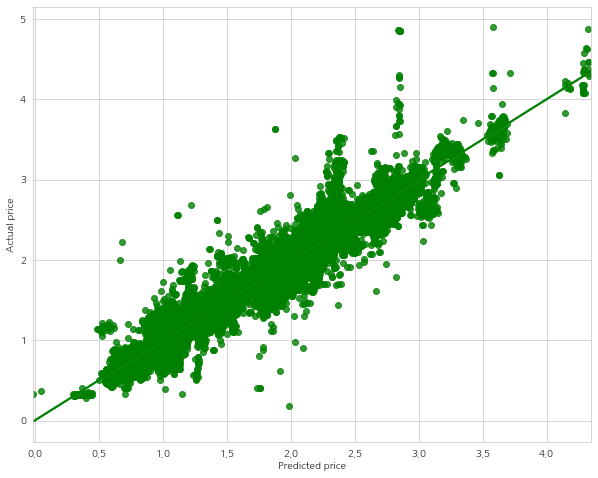

>> RMSE train = 0.20275027111091196
>> RMSE validation = 0.20951356007628996
>> MAE train = 0.13968316750224882
>> MAE validation = 0.1431794711971447
-------------------------------------------------


In [11]:
model0 = train_model(df0_base.drop(columns=['P_PRICE']), df0_base['P_PRICE'])

----
# Adding Weather Data
- df1_with_wf : 해안가여부 고려 없이 날씨 평균 데이터 추가
- df2_without_wf : 해안가인 지점 날씨 평균 데이터 추가

In [12]:
df1_with_wf = df_train.copy()
df2_without_wf = df_train.copy()

## Preprocess
- 이상치 제거 : 강수량과 풍속이 음수인 경우 제거
- '지점'에 따른 나라명 컬럼(CTRY_1)과 해안가여부(is_waterfront) 추가
- 각 나라, 일자 별로 평균 강수량, 풍속, 기온 계산

In [13]:
# 지점에 따라 나라명 추가
def set_country(row):
    data = df_weather_code[df_weather_code['지점'] == row['지점']]
    if data.empty:
        return ""
    return data.iloc[0]['국가명']


def set_waterfront(row):
    data = df_weather_code[df_weather_code['지점'] == row['지점']]
    if data.empty or data.iloc[0]['해안가여부'] != 1:
        return False
    return True
    

def preprocess_weather(df, drop_waterfront):
    df = df[(df['강수량'] >= 0) & (df['풍속'] >= 0)] # 이상치/결측치 제거
    set_week(df, '일시')  # 날짜 정보 처리
    
    # 1차 평균
    columns = ['year', 'week', '지점']
    df['rain'] = df[columns + ['강수량']].groupby(columns).transform('mean')
    df['wind'] = df[columns + ['풍속']].groupby(columns).transform('mean')
    df['temperature'] = df[columns + ['기온']].groupby(columns).transform('mean')
    
    # 나라명 추가
    df['CTRY_1'] = ""
    for i, row in df.iterrows():
        df.at[i, 'CTRY_1'] = set_country(row)
    
    # 해안가 여부 추가
    df['is_waterfront'] = False
    for i, row in df.iterrows():
        df.at[i, 'is_waterfront'] = set_waterfront(row)
     
    if drop_waterfront:
        df = df[df['is_waterfront']]  # 해안가가 아닌 데이터 제외
    
    # 2차 평균
    columns = ['year', 'week', 'CTRY_1']
    df['rain'] = df[columns + ['강수량']].groupby(columns).transform('mean')
    df['wind'] = df[columns + ['풍속']].groupby(columns).transform('mean')
    df['temperature'] = df[columns + ['기온']].groupby(columns).transform('mean')

    # 컬럼/행 정리
    df.drop(columns=['지점명', '지점', '강수량', '풍속', '기온', 'is_waterfront'], inplace=True)
    df.drop_duplicates(inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    return df

In [ ]:
weather_with_wf = []
weather_without_wf = []
for i in range(len(weather_list)):
    weather_with_wf.append(preprocess_weather(weather_list[i], False))
    weather_without_wf.append(preprocess_weather(weather_list[i], True))

In [ ]:
df_weather_with_wf = pd.concat(weather_with_wf)
df_weather_without_wf = pd.concat(weather_without_wf)

### Check

In [ ]:
print("=================해안가여부 고려X=====================")
for country in ["칠레", "중국", "노르웨이", "태국", "베트남"]:
    print(country, "총", len(df_weather_with_wf[df_weather_with_wf['CTRY_1'] == country]), "개")
    check_week(df_weather_with_wf[df_weather_with_wf['CTRY_1'] == country])
    print()
    
print("=================해안가여부 고려O=====================")
for country in ["칠레", "중국", "노르웨이", "태국", "베트남"]:
    print(country, "총", len(df_weather_without_wf[df_weather_without_wf['CTRY_1'] == country]), "개")
    check_week(df_weather_without_wf[df_weather_without_wf['CTRY_1'] == country])
    print()

### Filling Missing Values
- df_weather_with_wf : 태국, 베트남, 칠레에 결측치 1개씩
- df_weather_without_wf : 총 5개 결측치
- 결측치 > 전/차주 데이터 평균으로 채워넣기

In [ ]:
def get_avg(df, year, week, country, value):
    return (df[(df['year'] == year) &
               (df['week'] == week + 1) &
               (df['CTRY_1'] == country)].iloc[0][value] 
          + df[(df['year'] == year) &
               (df['week'] == week - 1) &
               (df['CTRY_1'] == country)].iloc[0][value]) / 2

In [ ]:
df_weather_with_wf = df_weather_with_wf.append({'year': 2016,
                                'week': 11,
                                'CTRY_1': '태국',
                                'rain': get_avg(df_weather_with_wf, 2016, 11, '태국', 'rain'),
                                'wind': get_avg(df_weather_with_wf, 2016, 11, '태국', 'wind'),
                                'temperature': get_avg(df_weather_with_wf, 2016, 11, '태국', 'temperature')},
                               ignore_index=True)
df_weather_with_wf = df_weather_with_wf.append({'year': 2016,
                                'week': 6,
                                'CTRY_1': '베트남',
                                'rain': get_avg(df_weather_with_wf, 2016, 6, '베트남', 'rain'),
                                'wind': get_avg(df_weather_with_wf, 2016, 6, '베트남', 'wind'),
                                'temperature': get_avg(df_weather_with_wf, 2016, 6, '베트남', 'temperature')},
                               ignore_index=True)
df_weather_with_wf = df_weather_with_wf.append({'year': 2016,
                                'week': 5,
                                'CTRY_1': '칠레',
                                'rain': get_avg(df_weather_with_wf, 2016, 5, '칠레', 'rain'),
                                'wind': get_avg(df_weather_with_wf, 2016, 5, '칠레', 'wind'),
                                'temperature': get_avg(df_weather_with_wf, 2016, 5, '칠레', 'temperature')},
                               ignore_index=True)

for country in ["태국", "베트남", "칠레"]:
    print()
    print(country, "총", len(df_weather_with_wf[df_weather_with_wf['CTRY_1'] == country]), "개")
    check_week(df_weather_with_wf[df_weather_with_wf['CTRY_1'] == country])

In [ ]:
df_weather_without_wf = df_weather_without_wf.append({'year': 2016,
                                'week': 11,
                                'CTRY_1': '태국',
                                'rain': get_avg(df_weather_without_wf, 2016, 11, '태국', 'rain'),
                                'wind': get_avg(df_weather_without_wf, 2016, 11, '태국', 'wind'),
                                'temperature': get_avg(df_weather_without_wf, 2016, 11, '태국', 'temperature')},
                               ignore_index=True)
df_weather_without_wf = df_weather_without_wf.append({'year': 2016,
                                'week': 15,
                                'CTRY_1': '태국',
                                'rain': get_avg(df_weather_without_wf, 2016, 15, '태국', 'rain'),
                                'wind': get_avg(df_weather_without_wf, 2016, 15, '태국', 'wind'),
                                'temperature': get_avg(df_weather_without_wf, 2016, 15, '태국', 'temperature')},
                               ignore_index=True)
df_weather_without_wf = df_weather_without_wf.append({'year': 2019,
                                'week': 10,
                                'CTRY_1': '태국',
                                'rain': get_avg(df_weather_without_wf, 2019, 10, '태국', 'rain'),
                                'wind': get_avg(df_weather_without_wf, 2019, 10, '태국', 'wind'),
                                'temperature': get_avg(df_weather_without_wf, 2019, 10, '태국', 'temperature')},
                               ignore_index=True)

df_weather_without_wf = df_weather_without_wf.append({'year': 2016,
                                'week': 6,
                                'CTRY_1': '베트남',
                                'rain': get_avg(df_weather_without_wf, 2016, 6, '베트남', 'rain'),
                                'wind': get_avg(df_weather_without_wf, 2016, 6, '베트남', 'wind'),
                                'temperature': get_avg(df_weather_without_wf, 2016, 6, '베트남', 'temperature')},
                               ignore_index=True)

df_weather_without_wf = df_weather_without_wf.append({'year': 2016,
                                'week': 5,
                                'CTRY_1': '칠레',
                                'rain': get_avg(df_weather_without_wf, 2016, 5, '칠레', 'rain'),
                                'wind': get_avg(df_weather_without_wf, 2016, 5, '칠레', 'wind'),
                                'temperature': get_avg(df_weather_without_wf, 2016, 5, '칠레', 'temperature')},
                               ignore_index=True)

for country in ["태국", "베트남", "칠레"]:
    print()
    print(country, "총", len(df_weather_without_wf[df_weather_without_wf['CTRY_1'] == country]), "개")
    check_week(df_weather_without_wf[df_weather_without_wf['CTRY_1'] == country])

### Merge Data

In [ ]:
df1_with_wf = pd.merge(df1_with_wf, df_weather_with_wf, how='left', on=['year', 'week', 'CTRY_1'])

In [ ]:
df2_without_wf = pd.merge(df2_without_wf, df_weather_without_wf, how='left', on=['year', 'week', 'CTRY_1'])

### One hot encoding

In [ ]:
one_hot = ['CTRY_1', 'CTRY_2', 'P_PURPOSE', 'CATEGORY_1', 'CATEGORY_2', 'P_NAME']
df1_with_wf = pd.get_dummies(df1_with_wf, columns=one_hot)
df2_without_wf = pd.get_dummies(df2_without_wf, columns=one_hot)

In [ ]:
df_weather_with_wf

## Train

In [ ]:
model1 = train_model(df1_with_wf.drop(columns=['P_PRICE']), df1_with_wf['P_PRICE'])

In [ ]:
t1 = print_importance(model1, df1_with_wf, ['rain', 'wind', 'temperature'])

In [ ]:
model2 = train_model(df2_without_wf.drop(columns=['P_PRICE']), df2_without_wf['P_PRICE'])

In [ ]:
t2 = print_importance(model2, df2_without_wf, ['rain', 'wind', 'temperature'])

- 날씨 데이터를 추가하는 것이 모델 정확도 상승에 영향을 준다
- 해안가가 아닌 데이터를 제거하는 것은 오히려 정확도를 떨어뜨린다
- 날씨 데이터를 전부 사용한다

----
# Adding Exchange Data
- df3_add_exchange : 수출국의 환율 데이터 추가

In [ ]:
df3_add_exchange = df_train.copy()

## Preprocess
### Merge Data

In [ ]:
df3_add_exchange = pd.merge(df3_add_exchange, df_weather_with_wf, how='left', on=['year', 'week', 'CTRY_1'])

In [ ]:
df3_add_exchange = pd.merge(df3_add_exchange, df_exchange, how='left', on=['year', 'week', 'CTRY_2'])

### One hot encoding

In [ ]:
one_hot = ['CTRY_1', 'CTRY_2', 'P_PURPOSE', 'CATEGORY_1', 'CATEGORY_2', 'P_NAME']
df3_add_exchange = pd.get_dummies(df3_add_exchange, columns=one_hot)

## Train

In [ ]:
model3 = train_model(df3_add_exchange.drop(columns=['P_PRICE']), df3_add_exchange['P_PRICE'])

In [ ]:
t3 = print_importance(model3, df3_add_exchange, ['exchange'])

- 미세하게 모델 정확도가 상승하였으므로 환율 데이터도 사용하도록 한다

----
# Adding Exchange Data
- df4_add_cpi : cpi 데이터 추가

In [ ]:
df4_add_cpi = df_train.copy()

## Preprocess
### Merge Data

In [ ]:
df4_add_cpi = pd.merge(df4_add_cpi, df_weather_with_wf, how='left', on=['year', 'week', 'CTRY_1'])

In [ ]:
df4_add_cpi = pd.merge(df4_add_cpi, df_exchange, how='left', on=['year', 'week', 'CTRY_2'])

In [ ]:
df4_add_cpi = pd.merge(df4_add_cpi, df_cpi, how='left', on=['year', 'week'])

In [ ]:
df4_add_cpi['cpi_total'] = df4_add_cpi['cpi_total_x']

df4_add_cpi.drop(['cpi_total_x','cpi_total_y'],axis=1,inplace=True)

### One hot encoding

In [ ]:
one_hot = ['CTRY_1', 'CTRY_2', 'P_PURPOSE', 'CATEGORY_1', 'CATEGORY_2', 'P_NAME']
df4_add_cpi = pd.get_dummies(df4_add_cpi, columns=one_hot)

## Train

In [ ]:
model4 = train_model(df4_add_cpi.drop(columns=['P_PRICE']), df4_add_cpi['P_PRICE'])

In [ ]:
t4 = print_importance(model4, df4_add_cpi, ['cpi_total','cpi_fish'])

- 미세하게 모델 정확도가 상승하였으므로 cpi 데이터도 사용하도록 한다

----
# Adding Korea Weather Data
- df5_add_weather_kr : 한국 날씨 데이터 추가

In [ ]:
df5_add_weather_kr = df_train.copy()

## Preprocess
### Merge Data

In [ ]:
df5_add_weather_kr = pd.merge(df5_add_weather_kr, df_weather_with_wf, how='left', on=['year', 'week', 'CTRY_1'])

In [ ]:
df5_add_weather_kr = pd.merge(df5_add_weather_kr, df_exchange, how='left', on=['year', 'week', 'CTRY_2'])

In [ ]:
df5_add_weather_kr = pd.merge(df5_add_weather_kr, df_cpi, how='left', on=['year', 'week'])

In [ ]:
df5_add_weather_kr = pd.merge(df5_add_weather_kr, df_weather_kr, how='left', on=['year', 'week'])

In [ ]:
df5_add_weather_kr['cpi_total'] = df5_add_weather_kr['cpi_total_x']
df5_add_weather_kr['wind_kr'] = df5_add_weather_kr['wind_kr_x']

df5_add_weather_kr.drop(['cpi_total_x','cpi_total_y','wind_kr_x','wind_kr_y'],axis=1,inplace=True)

### One hot encoding

In [ ]:
one_hot = ['CTRY_1', 'CTRY_2', 'P_PURPOSE', 'CATEGORY_1', 'CATEGORY_2', 'P_NAME']
df5_add_weather_kr = pd.get_dummies(df5_add_weather_kr, columns=one_hot)

## Train

In [ ]:
model5 = train_model(df5_add_weather_kr.drop(columns=['P_PRICE']), df5_add_weather_kr['P_PRICE'])

In [ ]:
t5 = print_importance(model5, df5_add_weather_kr, ['wind_kr','temp_kr','water_temp_kr'])

- 미세하게 모델 정확도가 상승하였으므로 한국 날씨 데이터도 사용하도록 한다

----
# Standardization

In [ ]:
df4_transform = df_train.copy()

## Preprocess
### Merge Data

In [ ]:
df4_transform = pd.merge(df4_transform, df_weather_with_wf, how='left', on=['year', 'week', 'CTRY_1'])

In [ ]:
df4_transform = pd.merge(df4_transform, df_exchange, how='left', on=['year', 'week', 'CTRY_2'])

In [ ]:
df4_transform = pd.merge(df4_transform, df_cpi, how='left', on=['year', 'week'])

In [ ]:
df4_transform = pd.merge(df4_transform, df_weather_kr, how='left', on=['year', 'week'])

In [ ]:
df4_transform['cpi_total'] = df4_transform['cpi_total_x']
df4_transform['wind_kr'] = df4_transform['wind_kr_x']

In [ ]:
df4_transform.drop(['cpi_total_x','cpi_total_y','wind_kr_x','wind_kr_y'],axis=1,inplace=True)

### Standardization
- 추가한 Numerical Feauture : wind, rain, temperature, exchange, oil, cpi_total,cpi_fish,wind_kr, temp_kr, water_temp_kr
- 이에 대해 분포를 확인한 후, 정규화를 진행한다

#### wind

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df4_transform['wind'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df4_transform['wind'], plot=plt)

plt.show()

- Peakedness & Skewedness
- Doesn't follow the diagonal line
- Use Log Transformation

In [ ]:
# Log Transformation
df4_transform['wind'] = np.log1p(df4_transform['wind'])

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df4_transform['wind'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df4_transform['wind'], plot=plt)

plt.show()

#### rain

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df4_transform['rain'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df4_transform['rain'], plot=plt)

plt.show()

- Peakedness & Skewedness
- Doesn't follow the diagonal line
- Use Log Transformation

In [ ]:
# Log Transformation
df4_transform['rain'] = np.log1p(df4_transform['rain'])

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df4_transform['rain'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df4_transform['rain'], plot=plt)

plt.show()

#### temperature

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df4_transform['temperature'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df4_transform['temperature'], plot=plt)

plt.show()

- Peakedness & Skewedness
- Doesn't follow the diagonal line
- Use Standardization

In [ ]:
# Standardization
# 로그 변환시 NaN 값 생성됨.
df4_transform['temperature'] = (df4_transform['temperature'] - np.mean(df4_transform['temperature'])) / df4_transform['temperature'].std()

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df4_transform['temperature'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df4_transform['temperature'], plot=plt)

plt.show()

#### exchange

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df4_transform['exchange'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df4_transform['exchange'], plot=plt)

plt.show()

- Peakedness & Skewedness
- Doesn't follow the diagonal line
- Use Standardization

In [ ]:
# Log Transformation
df4_transform['exchange'] = np.log1p(df4_transform['exchange'])

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df4_transform['exchange'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df4_transform['exchange'], plot=plt)

plt.show()

#### oil

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df4_transform['oil'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df4_transform['oil'], plot=plt)

plt.show()

- Peakedness & Skewedness
- Doesn't follow the diagonal line
- Use Log Transformation

In [ ]:
# Log Transformation
df4_transform['oil'] = np.log1p(df4_transform['oil'])

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df4_transform['oil'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df4_transform['oil'], plot=plt)

plt.show()

#### cpi_total

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df4_transform['cpi_total'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df4_transform['cpi_total'], plot=plt)

plt.show()

- Peakedness & Skewedness
- Doesn't follow the diagonal line
- Use Log Transformation

In [ ]:
# Log Transformation
df4_transform['cpi_total'] = np.log1p(df4_transform['cpi_total'])

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df4_transform['cpi_total'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df4_transform['cpi_total'], plot=plt)

plt.show()

#### cpi_fish

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df4_transform['cpi_fish'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df4_transform['cpi_fish'], plot=plt)

plt.show()

- Peakedness & Skewedness
- Doesn't follow the diagonal line
- Use Log Transformation

In [ ]:
# Log Transformation
df4_transform['cpi_fish'] = np.log1p(df4_transform['cpi_fish'])

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df4_transform['cpi_fish'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df4_transform['cpi_fish'], plot=plt)

plt.show()

#### wind_kr

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df4_transform['wind_kr'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df4_transform['wind_kr'], plot=plt)

plt.show()

- Peakedness & Skewedness
- Doesn't follow the diagonal line
- Use Log Transformation

In [ ]:
# Log Transformation
df4_transform['wind_kr'] = np.log1p(df4_transform['wind_kr'])

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df4_transform['wind_kr'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df4_transform['wind_kr'], plot=plt)

plt.show()

#### temp_kr

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df4_transform['temp_kr'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df4_transform['temp_kr'], plot=plt)

plt.show()

- Peakedness & Skewedness
- Doesn't follow the diagonal line
- Use Log Transformation

In [ ]:
# Log Transformation
df4_transform['temp_kr'] = np.log1p(df4_transform['temp_kr'])

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df4_transform['temp_kr'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df4_transform['temp_kr'], plot=plt)

plt.show()

#### water_temp_kr

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df4_transform['water_temp_kr'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df4_transform['water_temp_kr'], plot=plt)

plt.show()

- Peakedness & Skewedness
- Doesn't follow the diagonal line
- Use Log Transformation

In [ ]:
# Log Transformation
df4_transform['water_temp_kr'] = np.log1p(df4_transform['water_temp_kr'])

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df4_transform['water_temp_kr'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df4_transform['water_temp_kr'], plot=plt)

plt.show()

### One hot encoding

In [ ]:
one_hot = ['CTRY_1', 'CTRY_2', 'P_PURPOSE', 'CATEGORY_1', 'CATEGORY_2', 'P_NAME']
df4_transform = pd.get_dummies(df4_transform, columns=one_hot)

## Train

In [ ]:
model6 = train_model(df4_transform.drop(columns=['P_PRICE']), df4_transform['P_PRICE'])

In [ ]:
t4 = print_importance(model6, df4_transform, ['rain','wind','temperature','exchange','oil','cpi_total','cpi_fish','wind_kr','temp_kr','water_temp_kr'])

- exchange,temperature 변수 외의 다른 변수들은 순위가 별로 높지 않으며, 모델 성능이 크게 개선되지 않음을 발견할 수 있다
- 다만, 몇 없는 numerical feature 이므로 파생 변수를 추가하는 방향으로 고려해볼 수 있을 것이다

# Feature Selection (by Correlation)

In [ ]:
df5_feature_selection = df_train.copy()

In [ ]:
df5_feature_selection = pd.merge(df5_feature_selection, df_weather_with_wf, how='left', on=['year', 'week', 'CTRY_1'])

In [ ]:
df5_feature_selection = pd.merge(df5_feature_selection, df_exchange, how='left', on=['year', 'week', 'CTRY_2'])

In [ ]:
df5_feature_selection = pd.merge(df5_feature_selection, df_cpi, how='left', on=['year', 'week'])

In [ ]:
df5_feature_selection = pd.merge(df5_feature_selection, df_weather_kr, how='left', on=['year', 'week'])

In [ ]:
df5_feature_selection['cpi_total'] = df5_feature_selection['cpi_total_x']
df5_feature_selection['wind_kr'] = df5_feature_selection['wind_kr_x']

df5_feature_selection.drop(['cpi_total_x','cpi_total_y','wind_kr_x','wind_kr_y'],axis=1,inplace=True)

In [ ]:
columns = ['CTRY_1', 'CTRY_2', 'P_PURPOSE', 'CATEGORY_1', 'CATEGORY_2', 'P_NAME',
       'P_PRICE', 'year', 'week', 'ctry1_cnt', 'purpose_cnt', 'category1_cnt',
       'category2_cnt', 'name_cnt', 'is_processed', 'import_cnt','oil', 'wind_kr', 'cpi_total','cpi_fish' ,'temp_kr','water_temp_kr','rain','wind','temperature','exchange']

df5_feature_selection = df5_feature_selection[columns]

## Grouping by Correlation
- P_PRICE 와 상관관계가 높은 변수 찾기
- 서로 상관관계가 높은 변수 찾기

In [ ]:
#Using Pearson Correlation
plt.figure(figsize=(15,12))
cor = df5_feature_selection.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

- P_PRICE 와 상관계수가 큰 변수
    - 없음

- 서로간 상관계수가 큰 변수
    - year & oil & cpi_total & cpi_fish
    - week & temp_kr & water_temp_kr
    - category2_cnt & name_cnt
    - ctry1_cnt & exchange
    - rain & temperature
    - temp_kr & wind_kr


temperature_kr & wind_kr & water_temp_kr 평균 사용

cpi = cpi_fish / cpi_total 사용

In [ ]:
df5_feature_selection['weather_kr'] = (df5_feature_selection['temp_kr'] + df5_feature_selection['wind_kr']+df5_feature_selection['water_temp_kr']) / 3

df5_feature_selection['cpi'] = df5_feature_selection['cpi_fish'] / df5_feature_selection['cpi_total']

In [ ]:
df5_feature_selection.drop(columns=['temp_kr','wind_kr','water_temp_kr','cpi_fish','cpi_total'], axis=1, inplace=True)

## One Hot Encoding & Dropping

In [ ]:
# Others
one_hot = ['CTRY_1', 'CTRY_2', 'P_PURPOSE', 'CATEGORY_1', 'CATEGORY_2', 'P_NAME']
df5_feature_selection = pd.get_dummies(df5_feature_selection, columns=one_hot)

## Train

In [ ]:
model6 = train_model(df5_feature_selection.drop(columns=['P_PRICE']), df5_feature_selection['P_PRICE'])

In [ ]:
t5 = print_importance(model6, df5_feature_selection, columns)

정확도가 감소한 것을 확인할 수 있다  
그러나 다중공선성 문제를 피하기 위해서는 어쩔 수 없다

# Final DF

In [ ]:
df_final = df_train.copy()

In [ ]:
df_final

## Preprocessing

In [ ]:
df_final = pd.merge(df_final, df_weather_with_wf, how='left', on=['year', 'week', 'CTRY_1'])

In [ ]:
df_final = pd.merge(df_final, df_exchange, how='left', on=['year', 'week', 'CTRY_2'])

In [ ]:
df_final = pd.merge(df_final, df_cpi, how='left', on=['year', 'week'])

In [ ]:
df_final = pd.merge(df_final, df_weather_kr, how='left', on=['year', 'week'])

In [ ]:
df_final['cpi_total'] = df_final['cpi_total_x']
df_final['wind_kr'] = df_final['wind_kr_x']

df_final.drop(['cpi_total_x','cpi_total_y','wind_kr_x','wind_kr_y'],axis=1,inplace=True)

In [ ]:
# 정규화
df_final['wind'] = np.log1p(df_final['wind'])
df_final['rain'] = np.log1p(df_final['rain'])
df_final['exchange'] = np.log1p(df_final['exchange'])
df_final['oil'] = np.log1p(df_final['oil'])
df_final['cpi_total'] = np.log1p(df_final['cpi_total'])
df_final['wind_kr'] = np.log1p(df_final['wind_kr'])
df_final['temp_kr'] = np.log1p(df_final['temp_kr'])

df_final['temperature'] = (df_final['temperature'] - np.mean(df_final['temperature'])) / df_final['temperature'].std()

In [ ]:
# Grouping
df_final['weather_kr'] = (df_final['temp_kr'] + df_final['wind_kr']+df_final['water_temp_kr']) / 3

df_final['cpi'] = df_final['cpi_fish'] / df_final['cpi_total']

In [ ]:
# One Hot Encoding
one_hot = ['CTRY_1', 'CTRY_2', 'P_PURPOSE', 'CATEGORY_1', 'CATEGORY_2', 'P_NAME']
df_final = pd.get_dummies(df_final, columns=one_hot)

In [ ]:
# Drop
df_final.drop(columns=['temp_kr','wind_kr','water_temp_kr','cpi_fish','cpi_total'], axis=1, inplace=True)

## Train

In [ ]:
model = train_model(df_final.drop(columns=['P_PRICE']), df_final['P_PRICE'])

In [ ]:
final_fs = print_importance(model, df_final, [])

## Save

In [ ]:
df_final.to_csv(os.path.join(root, "preprocessed_train_2.csv"), encoding='utf-8', index=False)

어종별 데이터프레임
- df_squid
- df_salmon
- df_whiteleg_shrimp

어종별 데이터프레임도 위 과정과 마찬가지로 어종별 주요 제조국/수출국만을 대상으로 추출

# df_squid

In [ ]:
df_squid = df_train[(df_train['P_NAME']=='오징어') & ((df_train['CTRY_1']=='페루') | (df_train['CTRY_1']=='중국') | (df_train['CTRY_1']=='칠레')) & ((df_train['CTRY_2']=='페루') | (df_train['CTRY_2']=='중국') | (df_train['CTRY_2']=='칠레'))]

df_squid = df_squid[['CTRY_1','CTRY_2','P_PRICE','year','week']]

df_squid

## Merge Features
### 모든 추가변수들을 포함

In [ ]:
df_squid_add = df_squid.copy()

In [ ]:
df_squid_add = pd.merge(df_squid_add, df_weather_with_wf, how='left', on=['year', 'week', 'CTRY_1'])

In [ ]:
df_squid_add = pd.merge(df_squid_add, df_weather_kr, how='left', on=['year', 'week'])

In [ ]:
df_squid_add = pd.merge(df_squid_add, df_oil, how='left', on=['year', 'week'])

In [ ]:
df_squid_add = pd.merge(df_squid_add, df_cpi, how='left', on=['year', 'week'])

In [ ]:
df_squid_add = pd.merge(df_squid_add, df_exchange, how='left', on=['year', 'week', 'CTRY_2'])

In [ ]:
df_squid_add = df_squid_add.sort_values('CTRY_2')

## Filling Missing Value

In [ ]:
df_squid_add.isna().sum()

## Grouping

In [ ]:
df_squid_add = df_squid_add.groupby(['year','week']).mean()

### train

In [ ]:
model6 = train_model(df_squid_add.drop(columns=['P_PRICE']), df_squid_add['P_PRICE'])

In [ ]:
t6 = print_importance(model6, df_squid_add, [])

## Standardization
- 추가한 Numerical Feauture : wind, rain, temperature, exchange, oil, cpi_total, cpi_fish,wind_kr, temperature_kr, water_temp_kr
- 이에 대해 분포를 확인한 후, 정규화를 진행한다

#### wind

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_squid_add['wind'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_squid_add['wind'], plot=plt)

plt.show()

- Peakedness & Skewedness
- Doesn't follow the diagonal line
- Use Log Transformation

In [ ]:
# Log Transformation
df_squid_add['wind'] = np.log1p(df_squid_add['wind'])

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_squid_add['wind'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_squid_add['wind'], plot=plt)

plt.show()

#### rain

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_squid_add['rain'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_squid_add['rain'], plot=plt)

plt.show()

- Peakedness & Skewedness
- Doesn't follow the diagonal line
- Use Log Transformation

In [ ]:
# Log Transformation
df_squid_add['rain'] = np.log1p(df_squid_add['rain'])

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_squid_add['rain'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_squid_add['rain'], plot=plt)

plt.show()

#### temperature

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_squid_add['temperature'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_squid_add['temperature'], plot=plt)

plt.show()

- Peakedness & Skewedness
- Doesn't follow the diagonal line
- Use Standardization

In [ ]:
# Standardization
df_squid_add['temperature'] = (df_squid_add['temperature']- np.mean(df_squid_add['temperature'])) / df_squid_add['temperature'].std()

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_squid_add['temperature'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_squid_add['temperature'], plot=plt)

plt.show()

#### exchange

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_squid_add['exchange'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_squid_add['exchange'], plot=plt)

plt.show()

- Peakedness & Skewedness
- Doesn't follow the diagonal line
- Use Log Transformation

In [ ]:
# Log Transformation
df_squid_add['exchange'] = np.log1p(df_squid_add['exchange'])

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_squid_add['exchange'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_squid_add['exchange'], plot=plt)

plt.show()

#### oil

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_squid_add['oil'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_squid_add['oil'], plot=plt)

plt.show()

- Peakedness & Skewedness
- Doesn't follow the diagonal line
- Use Log Transformation

In [ ]:
# Log Transformation
df_squid_add['oil'] = np.log1p(df_squid_add['oil'])

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_squid_add['oil'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_squid_add['oil'], plot=plt)

plt.show()

#### cpi_total

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_squid_add['cpi_total'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_squid_add['cpi_total'], plot=plt)

plt.show()

- Peakedness & Skewedness
- Doesn't follow the diagonal line
- Use Log Transformation

In [ ]:
# Log Transformation
df_squid_add['cpi_total'] = np.log1p(df_squid_add['cpi_total'])

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_squid_add['cpi_total'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_squid_add['cpi_total'], plot=plt)

plt.show()

#### cpi_fish

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_squid_add['cpi_fish'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_squid_add['cpi_fish'], plot=plt)

plt.show()

- Peakedness & Skewedness
- Doesn't follow the diagonal line
- Use Log Transformation

In [ ]:
# Log Transformation
df_squid_add['cpi_fish'] = np.log1p(df_squid_add['cpi_fish'])

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_squid_add['cpi_fish'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_squid_add['cpi_fish'], plot=plt)

plt.show()

#### wind_kr

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_squid_add['wind_kr'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_squid_add['wind_kr'], plot=plt)

plt.show()

- Use Standardization

In [ ]:
# Standardization
df_squid_add['wind_kr'] = (df_squid_add['wind_kr']- np.mean(df_squid_add['wind_kr'])) / df_squid_add['wind_kr'].std()

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_squid_add['wind_kr'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_squid_add['wind_kr'], plot=plt)

plt.show()

#### temperature_kr

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_squid_add['temperature_kr'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_squid_add['temperature_kr'], plot=plt)

plt.show()

- Use Standardization

In [ ]:
# Standardization
df_squid_add['temperature_kr'] = (df_squid_add['temperature_kr']- np.mean(df_squid_add['temperature_kr'])) / df_squid_add['temperature_kr'].std()

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_squid_add['temperature_kr'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_squid_add['temperature_kr'], plot=plt)

plt.show()

#### water_temp_kr

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_squid_add['water_temp_kr'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_squid_add['water_temp_kr'], plot=plt)

plt.show()

- Peakedness & Skewedness
- Doesn't follow the diagonal line
- Use Log Transformation

In [ ]:
# Log Transformation
df_squid_add['water_temp_kr'] = np.log1p(df_squid_add['water_temp_kr'])

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_squid_add['water_temp_kr'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_squid_add['water_temp_kr'], plot=plt)

plt.show()

## Train

In [ ]:
model7 = train_model(df_squid_add.drop(columns=['P_PRICE']), df_squid_add['P_PRICE'])

In [ ]:
t7 = print_importance(model7, df_squid_add, ['rain','wind','temperature','exchange','oil','cpi_total','cpi_fish','wind_kr','temperature_kr','water_temp_kr'])

정확도가 약간 증가하였으므로 해당 추가변수들을 모두 사용

## Feature Selection (by Correlation)

In [ ]:
plt.figure(figsize=(15,10))

sns.heatmap(df_squid_add.corr(), annot=True, cmap=plt.cm.Reds)
plt.show()

- P_PRICE 와 상관계수가 큰 변수
    - exchange, cpi_fish, cpi_total, oil

- 서로간 상관계수가 큰 변수
    - rain & temperature_kr & temperature & wind_kr
    - temperature_kr & water_temp_kr
    - oil & cpi_total & cpi_fish
    - cpi_fish & exchange

wind_kr & temperature_kr & water_temp_kr 평균 사용

cpi_fish / cpi_total 사용

In [ ]:
df_squid_add['temp_kr'] = (df_squid_add['temperature_kr'] + df_squid_add['water_temp_kr'] + df_squid_add['wind_kr']) / 3
df_squid_add['cpi'] = df_squid_add['cpi_fish'] / df_squid_add['cpi_total'] 

In [ ]:
df_squid_add.drop(columns=['temperature_kr', 'cpi_fish', 'water_temp_kr', 'wind_kr','cpi_total'], axis=1, inplace=True)

### Train

In [ ]:
model8 = train_model(df_squid_add.drop(columns=['P_PRICE']), df_squid_add['P_PRICE'])

In [ ]:
t8 = print_importance(model8, df_squid_add, ['temp_kr','cpi'])

정확도가 감소한 것을 확인할 수 있다  
그러나 다중공선성 문제를 피하기 위해서는 어쩔 수 없다

## Final DF

In [ ]:
df_final_squid = df_squid_add.copy()

# df_salmon

In [ ]:
df_salmon = df_train[(df_train['P_NAME']=='연어') & (df_train['CTRY_1']=='노르웨이') & (df_train['CTRY_2']=='노르웨이') ]

df_salmon = df_salmon[['CTRY_1','CTRY_2','P_PRICE','year','week']]

df_salmon

## Merge Features

In [ ]:
df_salmon_add = df_salmon.copy()

In [ ]:
df_salmon_add = pd.merge(df_salmon_add, df_weather_kr, how='left', on=['year', 'week'])

In [ ]:
df_salmon_add = pd.merge(df_salmon_add, df_weather_with_wf, how='left', on=['year', 'week', 'CTRY_1'])

In [ ]:
df_salmon_add = pd.merge(df_salmon_add, df_oil, how='left', on=['year', 'week'])

In [ ]:
df_salmon_add = pd.merge(df_salmon_add, df_cpi, how='left', on=['year', 'week'])

In [ ]:
df_salmon_add = pd.merge(df_salmon_add, df_exchange, how='left', on=['year', 'week', 'CTRY_2'])

## Filling Missing Value

In [ ]:
df_salmon_add.isna().sum()

## Grouping

In [ ]:
df_salmon_add = df_salmon_add.groupby(['year','week']).mean()

df_salmon_add

### train

In [ ]:
model9 = train_model(df_salmon_add.drop(columns=['P_PRICE']), df_salmon_add['P_PRICE'])

In [ ]:
t9 = print_importance(model9, df_salmon_add, [])

## Standardization
- 추가한 Numerical Feauture : wind, rain, temperature, exchange, oil, cpi_total, cpi_fish,wind_kr, temperature_kr, water_temp_kr
- 이에 대해 분포를 확인한 후, 정규화를 진행한다

#### wind

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_salmon_add['wind'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_salmon_add['wind'], plot=plt)

plt.show()

- Peakedness & Skewedness
- Doesn't follow the diagonal line
- Use Log Transformation

In [ ]:
# Log Transformation
df_salmon_add['wind'] = np.log1p(df_salmon_add['wind'])

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_salmon_add['wind'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_salmon_add['wind'], plot=plt)

plt.show()

#### rain

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_salmon_add['rain'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_salmon_add['rain'], plot=plt)

plt.show()

- Peakedness & Skewedness
- Doesn't follow the diagonal line
- Use Log Transformation

In [ ]:
# Log Transformation
df_salmon_add['rain'] = np.log1p(df_salmon_add['rain'])

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_salmon_add['rain'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_salmon_add['rain'], plot=plt)

plt.show()

#### temperature

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_salmon_add['temperature'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_salmon_add['temperature'], plot=plt)

plt.show()

- Peakedness & Skewedness
- Doesn't follow the diagonal line
- Use Standardization

In [ ]:
# Standardization
df_salmon_add['temperature'] = (df_salmon_add['temperature']- np.mean(df_salmon_add['temperature'])) / df_salmon_add['temperature'].std()

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_salmon_add['temperature'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_salmon_add['temperature'], plot=plt)

plt.show()

#### exchange

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_salmon_add['exchange'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_salmon_add['exchange'], plot=plt)

plt.show()

- Peakedness & Skewedness
- Doesn't follow the diagonal line
- Use Log Transformation

In [ ]:
# Log Transformation
df_salmon_add['exchange'] = np.log1p(df_salmon_add['exchange'])

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_salmon_add['exchange'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_salmon_add['exchange'], plot=plt)

plt.show()

#### oil

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_salmon_add['oil'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_salmon_add['oil'], plot=plt)

plt.show()

- Peakedness & Skewedness
- Doesn't follow the diagonal line
- Use Log Transformation

In [ ]:
# Log Transformation
df_salmon_add['oil'] = np.log1p(df_salmon_add['oil'])

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_salmon_add['oil'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_salmon_add['oil'], plot=plt)

plt.show()

#### cpi_total

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_salmon_add['cpi_total'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_salmon_add['cpi_total'], plot=plt)

plt.show()

- Peakedness & Skewedness
- Doesn't follow the diagonal line
- Use Log Transformation

In [ ]:
# Log Transformation
df_salmon_add['cpi_total'] = np.log1p(df_salmon_add['cpi_total'])

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_salmon_add['cpi_total'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_salmon_add['cpi_total'], plot=plt)

plt.show()

#### cpi_fish

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_salmon_add['cpi_fish'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_salmon_add['cpi_fish'], plot=plt)

plt.show()

- Peakedness & Skewedness
- Doesn't follow the diagonal line
- Use Log Transformation

In [ ]:
# Log Transformation
df_salmon_add['cpi_fish'] = np.log1p(df_salmon_add['cpi_fish'])

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_salmon_add['cpi_fish'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_salmon_add['cpi_fish'], plot=plt)

plt.show()

#### wind_kr

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_salmon_add['wind_kr'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_salmon_add['wind_kr'], plot=plt)

plt.show()

- Peakedness & Skewedness
- Doesn't follow the diagonal line
- Use Log Transformation

In [ ]:
# Log Transformation
df_salmon_add['wind_kr'] = np.log1p(df_salmon_add['wind_kr'])

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_salmon_add['wind_kr'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_salmon_add['wind_kr'], plot=plt)

plt.show()

#### temperature_kr

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_salmon_add['temperature_kr'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_salmon_add['temperature_kr'], plot=plt)

plt.show()

- Use Standardization

In [ ]:
# Standardization
df_salmon_add['temperature'] = (df_salmon_add['temperature']- np.mean(df_salmon_add['temperature'])) / df_salmon_add['temperature'].std()

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_salmon_add['temperature_kr'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_salmon_add['temperature_kr'], plot=plt)

plt.show()

#### water_temp_kr

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_salmon_add['water_temp_kr'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_salmon_add['water_temp_kr'], plot=plt)

plt.show()

- Peakedness & Skewedness
- Doesn't follow the diagonal line
- Use Log Transformation

In [ ]:
# Log Transformation
df_salmon_add['water_temp_kr'] = np.log1p(df_salmon_add['water_temp_kr'])

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_salmon_add['water_temp_kr'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_salmon_add['water_temp_kr'], plot=plt)

plt.show()

In [ ]:
model10 = train_model(df_salmon_add.drop(columns=['P_PRICE']), df_salmon_add['P_PRICE'])

In [ ]:
t10 = print_importance(model10, df_salmon_add, ['rain','wind','temperature','exchange','oil','cpi_total','cpi_fish','wind_kr','temperature_kr','water_temp_kr'])

정확도가 약간 증가하였으므로 해당 추가변수들을 모두 사용

## Feature Selection (by Correlation)

In [ ]:
plt.figure(figsize=(15,10))

sns.heatmap(df_salmon_add.corr(), annot=True, cmap=plt.cm.Reds)
plt.show()

- P_PRICE 와 상관계수가 큰 변수
    - 없음

- 서로간 상관계수가 큰 변수
    - rain & temperature_kr & temperature & wind_kr
    - temperature_kr & water_temp_kr
    - oil & cpi_total & cpi_fish

wind_kr & temperature_kr & water_temp_kr 평균 사용

cpi_fish / cpi_total 사용

In [ ]:
df_salmon_add['temp_kr'] = (df_salmon_add['temperature_kr'] + df_salmon_add['water_temp_kr'] + df_salmon_add['wind_kr']) / 3
df_salmon_add['cpi'] = df_salmon_add['cpi_fish'] / df_salmon_add['cpi_total'] 

In [ ]:
df_salmon_add.drop(columns=['temperature_kr', 'cpi_fish', 'water_temp_kr','wind_kr' ,'cpi_total'], axis=1, inplace=True)

### Train

In [ ]:
model11 = train_model(df_salmon_add.drop(columns=['P_PRICE']), df_salmon_add['P_PRICE'])

In [ ]:
t11 = print_importance(model11, df_salmon_add, ['temp_kr','cpi'])

정확도가 감소한 것을 확인할 수 있다  
그러나 다중공선성 문제를 피하기 위해서는 어쩔 수 없다

## Final DF

In [ ]:
df_final_salmon = df_salmon_add.copy()

# df_whiteleg_shrimp

In [ ]:
df_whiteleg_shrimp = df_train[(df_train['P_NAME']=='흰다리새우') & ((df_train['CTRY_1']=='베트남') | (df_train['CTRY_1']=='태국')) & ((df_train['CTRY_2']=='베트남') | (df_train['CTRY_2']=='태국'))]

df_whiteleg_shrimp = df_whiteleg_shrimp[['CTRY_1','CTRY_2','P_PRICE','year','week']]

df_whiteleg_shrimp

## Merge Features

In [ ]:
df_whiteleg_shrimp_add = df_whiteleg_shrimp.copy()

In [ ]:
df_whiteleg_shrimp_add = pd.merge(df_whiteleg_shrimp, df_weather_kr, how='left', on=['year', 'week'])

In [ ]:
df_whiteleg_shrimp_add = pd.merge(df_whiteleg_shrimp_add, df_weather_with_wf, how='left', on=['year', 'week', 'CTRY_1'])

In [ ]:
df_whiteleg_shrimp_add = pd.merge(df_whiteleg_shrimp_add, df_oil, how='left', on=['year', 'week'])

In [ ]:
df_whiteleg_shrimp_add = pd.merge(df_whiteleg_shrimp_add, df_cpi, how='left', on=['year', 'week'])

In [ ]:
df_whiteleg_shrimp_add = pd.merge(df_whiteleg_shrimp_add, df_exchange, how='left', on=['year', 'week', 'CTRY_2'])

## Filling Missing Value

In [ ]:
df_whiteleg_shrimp_add.isna().sum()

## Grouping

In [ ]:
df_whiteleg_shrimp_add = df_whiteleg_shrimp_add.groupby(['year','week']).mean()

df_whiteleg_shrimp_add

### train

In [ ]:
model12 = train_model(df_whiteleg_shrimp_add.drop(columns=['P_PRICE']), df_whiteleg_shrimp_add['P_PRICE'])

In [ ]:
t12 = print_importance(model12, df_whiteleg_shrimp_add, [])

## Standardization
- 추가한 Numerical Feauture : wind, rain, temperature, exchange, oil, cpi_total, cpi_fish,wind_kr, temperature_kr, water_temp_kr
- 이에 대해 분포를 확인한 후, 정규화를 진행한다

#### wind

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_whiteleg_shrimp_add['wind'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_whiteleg_shrimp_add['wind'], plot=plt)

plt.show()

- Peakedness & Skewedness
- Doesn't follow the diagonal line
- Use Log Transformation

In [ ]:
# Log Transformation
df_whiteleg_shrimp_add['wind'] = np.log1p(df_whiteleg_shrimp_add['wind'])

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_whiteleg_shrimp_add['wind'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_whiteleg_shrimp_add['wind'], plot=plt)

plt.show()

#### rain

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_whiteleg_shrimp_add['rain'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_whiteleg_shrimp_add['rain'], plot=plt)

plt.show()

- Peakedness & Skewedness
- Doesn't follow the diagonal line
- Use Log Transformation

In [ ]:
# Log Transformation
df_whiteleg_shrimp_add['rain'] = np.log1p(df_whiteleg_shrimp_add['rain'])

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_whiteleg_shrimp_add['rain'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_whiteleg_shrimp_add['rain'], plot=plt)

plt.show()

#### temperature

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_whiteleg_shrimp_add['temperature'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_whiteleg_shrimp_add['temperature'], plot=plt)

plt.show()

- Peakedness & Skewedness
- Doesn't follow the diagonal line
- Use Standardization

In [ ]:
# Standardization
df_whiteleg_shrimp_add['temperature'] = (df_whiteleg_shrimp_add['temperature']- np.mean(df_whiteleg_shrimp_add['temperature'])) / df_whiteleg_shrimp_add['temperature'].std()

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_whiteleg_shrimp_add['temperature'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_whiteleg_shrimp_add['temperature'], plot=plt)

plt.show()

#### exchange

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_whiteleg_shrimp_add['exchange'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_whiteleg_shrimp_add['exchange'], plot=plt)

plt.show()

- Peakedness & Skewedness
- Doesn't follow the diagonal line
- Use Log Transformation

In [ ]:
# Log Transformation
df_whiteleg_shrimp_add['exchange'] = np.log1p(df_whiteleg_shrimp_add['exchange'])

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_whiteleg_shrimp_add['exchange'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_whiteleg_shrimp_add['exchange'], plot=plt)

plt.show()

#### oil

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_whiteleg_shrimp_add['oil'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_whiteleg_shrimp_add['oil'], plot=plt)

plt.show()

- Peakedness & Skewedness
- Doesn't follow the diagonal line
- Use Log Transformation

In [ ]:
# Log Transformation
df_whiteleg_shrimp_add['oil'] = np.log1p(df_whiteleg_shrimp_add['oil'])

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_whiteleg_shrimp_add['oil'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_whiteleg_shrimp_add['oil'], plot=plt)

plt.show()

#### cpi_total

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_whiteleg_shrimp_add['cpi_total'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_whiteleg_shrimp_add['cpi_total'], plot=plt)

plt.show()

- Peakedness & Skewedness
- Doesn't follow the diagonal line
- Use Log Transformation

In [ ]:
# Log Transformation
df_whiteleg_shrimp_add['cpi_total'] = np.log1p(df_whiteleg_shrimp_add['cpi_total'])

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_whiteleg_shrimp_add['cpi_total'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_whiteleg_shrimp_add['cpi_total'], plot=plt)

plt.show()

#### cpi_fish

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_whiteleg_shrimp_add['cpi_fish'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_whiteleg_shrimp_add['cpi_fish'], plot=plt)

plt.show()

- Peakedness & Skewedness
- Doesn't follow the diagonal line
- Use Log Transformation

In [ ]:
# Log Transformation
df_whiteleg_shrimp_add['cpi_fish'] = np.log1p(df_whiteleg_shrimp_add['cpi_fish'])

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_whiteleg_shrimp_add['cpi_fish'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_whiteleg_shrimp_add['cpi_fish'], plot=plt)

plt.show()

#### wind_kr

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_whiteleg_shrimp_add['wind_kr'], fit=norm)

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_whiteleg_shrimp_add['wind_kr'], plot=plt)

plt.show()

- Peakedness & Skewedness
- Doesn't follow the diagonal line
- Use Log Transformation

In [ ]:
# Log Transformation
df_whiteleg_shrimp_add['wind_kr'] = np.log1p(df_whiteleg_shrimp_add['wind_kr'])

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_whiteleg_shrimp_add['wind_kr'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_whiteleg_shrimp_add['wind_kr'], plot=plt)

plt.show()

#### temperature_kr

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_whiteleg_shrimp_add['temperature_kr'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_whiteleg_shrimp_add['temperature_kr'], plot=plt)

plt.show()

- Use Standardization

In [ ]:
# Standardization
df_whiteleg_shrimp_add['temperature'] = (df_whiteleg_shrimp_add['temperature']- np.mean(df_whiteleg_shrimp_add['temperature'])) / df_whiteleg_shrimp_add['temperature'].std()

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_whiteleg_shrimp_add['temperature_kr'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_whiteleg_shrimp_add['temperature_kr'], plot=plt)

plt.show()

#### water_temp_kr

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_whiteleg_shrimp_add['water_temp_kr'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_whiteleg_shrimp_add['water_temp_kr'], plot=plt)

plt.show()

- Peakedness & Skewedness
- Doesn't follow the diagonal line
- Use Log Transformation

In [ ]:
# Log Transformation
df_whiteleg_shrimp_add['water_temp_kr'] = np.log1p(df_whiteleg_shrimp_add['water_temp_kr'])

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df_whiteleg_shrimp_add['water_temp_kr'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df_whiteleg_shrimp_add['water_temp_kr'], plot=plt)

plt.show()

In [ ]:
model13 = train_model(df_whiteleg_shrimp_add.drop(columns=['P_PRICE']), df_whiteleg_shrimp_add['P_PRICE'])

In [ ]:
t13 = print_importance(model13, df_whiteleg_shrimp_add, ['rain','wind','temperature','exchange','oil','cpi_total','cpi_fish','wind_kr','temperature_kr','water_temp_kr'])

정확도가 약간 증가하였으므로 해당 추가변수들을 모두 사용

## Feature Selection (by Correlation)

In [ ]:
plt.figure(figsize=(15,10))

sns.heatmap(df_whiteleg_shrimp_add.corr(), annot=True, cmap=plt.cm.Reds)
plt.show()

- P_PRICE 와 상관계수가 큰 변수
    - 없음

- 서로간 상관계수가 큰 변수
    - rain & temperature_kr & temperature & water_temp_kr & wind_kr
    - oil & cpi_total & cpi_fish
    
temperature_kr & water_temp_kr 평균 사용

cpi_fish / cpi_total 사용

In [ ]:
df_whiteleg_shrimp_add['temp_kr'] = (df_whiteleg_shrimp_add['temperature_kr'] + df_whiteleg_shrimp_add['water_temp_kr'] + df_whiteleg_shrimp_add['wind_kr']) / 3
df_whiteleg_shrimp_add['cpi'] = df_whiteleg_shrimp_add['cpi_fish'] / df_whiteleg_shrimp_add['cpi_total'] 

In [ ]:
df_whiteleg_shrimp_add.drop(columns=['temperature_kr', 'cpi_fish', 'water_temp_kr','wind_kr' ,'cpi_total'], axis=1, inplace=True)

### Train

In [ ]:
model14 = train_model(df_whiteleg_shrimp_add.drop(columns=['P_PRICE']), df_whiteleg_shrimp_add['P_PRICE'])

In [ ]:
t14 = print_importance(model14, df_whiteleg_shrimp_add, ['temp_kr','cpi'])

정확도가 감소한 것을 확인할 수 있다  
그러나 다중공선성 문제를 피하기 위해서는 어쩔 수 없다

## Final DF

In [ ]:
df_final_whiteleg_shrimp = df_whiteleg_shrimp_add.copy()

# Save

In [ ]:
df_final_squid.to_csv(os.path.join(root, "final_squid.csv"), encoding='utf-8', index=False)
df_final_salmon.to_csv(os.path.join(root, "final_salmon.csv"), encoding='utf-8', index=False)
df_final_whiteleg_shrimp.to_csv(os.path.join(root, "final_whiteleg_shrimp.csv"), encoding='utf-8', index=False)